In [13]:
import numpy as np

In [84]:
import theano
import theano.tensor as T

k = T.iscalar("k")
A = T.vector("A")

# Symbolic description of the result
result, updates = theano.scan(fn=lambda prior_result, A: prior_result * A,
                              outputs_info=T.ones_like(A),
                              non_sequences=A,
                              n_steps=k)

# We only care about A**k, but scan has provided us with A**1 through A**k.
# Discard the values that we don't care about. Scan is smart enough to
# notice this and not waste memory saving them.
final_result = result[-1]

# compiled function that returns A**k
power = theano.function(inputs=[A,k], outputs=final_result, updates=updates)

print "We will Come back to this and understand it in detail"

We will Come back to this and understand it in detail


In [85]:

print(power(range(10),2))
print(power(range(1),4))

[  0.   1.   4.   9.  16.  25.  36.  49.  64.  81.]
[ 0.]


In [12]:
# What's the lambda thing ?
fn=lambda prior_result, A: prior_result * A
fn(4,2)
# It is basically functions


8

## Accumulation
### In the scan operator, the first parameter of the lambda function is the  accumulated variable from the last iteration

In [82]:
x = T.scalar()

acc,upd = theano.scan(fn = lambda temp : temp + 1, outputs_info=theano.shared(np.zeros(1)),n_steps=k)


* Temp accumulates the result.

* outputs_info stores the initial value of the accumulator

* n_steps tells the number of iteration

In [83]:
acc_fn = theano.function([k],acc,updates=upd)

* Hence, the parameter here is only the number of times to add 1

In [29]:
print acc_fn(3)

[[ 1.]
 [ 2.]
 [ 3.]]


#### Variable Accumulator

In [88]:
x = T.scalar()
inc = T.scalar()
acc,upd = theano.scan(fn = lambda temp, inc : temp + inc, outputs_info=theano.shared(np.zeros(1)),non_sequences = inc, n_steps=k)


* __inc__ is a scalar, which is added to the accumulator in each iteration
* In a for loop, you can equate __non_sequences__ to variables that is used wholly in each iteration
> Consider this C for  loop
>  <pre><code> for (i = 1; i < 10; i++)
 >   sum = sum + a
 > </pre></code>

* Here , a is added in each iteration. These variables go in the non_sequences block

In [89]:

acc_fn = theano.function([inc,k],acc,updates=upd)

+ So, now we have two parameters __inc__ and __k__

In [90]:
acc_fn(2,3)

array([[ 2.],
       [ 4.],
       [ 6.]])

* We can have more non_sequence variables
> Consider the following piece of code
> <pre> <code> for (i = 1; i < k ; i++)
>        x = x * s + t 
       </code></pre>

In [59]:
s = T.scalar('s')
t = T.scalar('t')
def odd_inc(x,s,t):
    x = x * s + t
    return x

acc,upd = theano.scan(fn = odd_inc, outputs_info=theano.shared(np.zeros(1)),non_sequences = [t,s], n_steps=k)

acc_fn = theano.function([s,k,t],acc,updates=upd)

In [60]:
acc_fn(2,5,4)

array([[   2.],
       [  10.],
       [  42.],
       [ 170.],
       [ 682.]])

## No Accumulation

#### If there no accumulation of results, we can set __outputs_info__ to None. This indicates to scan that it doesn’t need to pass the prior result to fn. ####

> The general order of function parameters to fn is:

> <pre><code>fn(sequences (if any), prior result(s) (if needed), non-sequences (if any))</code></pre>

### Dot Product

In [111]:
s = T.vector('s')
t = T.vector('t')

def vec_mul(s,t):
    x = s * t
    return x

acc,upd = theano.scan(fn = vec_mul, outputs_info = None, sequences = [s,t])

acc_fn = theano.function([s,t],acc,updates=upd)

### And then sum up the results
> We do an elementwise multiplication and then add them up

Equate this with the following block of code 
> <pre> <code> for (i = 1; i< 10; i++)
>         x[i] = s[i] * t[i]
</code> </pre>

In [115]:
acc_fn(np.asarray([3,1,2]),np.asarray([2,2,2])).sum()

12.0

### Note the order of arguements in vec_mul().
> Try and see what happens if you put s at the beginning

In [121]:
s = T.vector('s')
t = T.vector('t')
def vec_mul(s,t,x):
    v =  s * t
    return v
outputs_info = T.as_tensor_variable(np.asarray(0, np.float64))
acc,upd = theano.scan(fn = vec_mul, outputs_info = outputs_info, sequences = [s,t])

acc_fn = theano.function([s,t],acc,updates=upd)

In [124]:
acc_fn([3,2,3],[2, 4,5])

array([  6.,   8.,  15.])

# Logistic Regression

In [129]:
class LogisticRegression(object):
    """Multi-class Logistic Regression Class

    The logistic regression is fully described by a weight matrix :math:`W`
    and bias vector :math:`b`. Classification is done by projecting data
    points onto a set of hyperplanes, the distance to which is used to
    determine a class membership probability.
    """

    def __init__(self, input, n_in, n_out):
        """ Initialize the parameters of the logistic regression

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
                      architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
                     which the datapoints lie

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
                      which the labels lie

        """
        # start-snippet-1
        # initialize with 0 the weights W as a matrix of shape (n_in, n_out)
        self.W = theano.shared(
            value=np.zeros(
                (n_in, n_out),
                dtype=theano.config.floatX
            ),
            name='W',
            borrow=True
        )
        # initialize the biases b as a vector of n_out 0s
        self.b = theano.shared(
            value=np.zeros(
                (n_out,),
                dtype=theano.config.floatX
            ),
            name='b',
            borrow=True
        )

        # symbolic expression for computing the matrix of class-membership
        # probabilities
        # Where:
        # W is a matrix where column-k represent the separation hyperplane for
        # class-k
        # x is a matrix where row-j  represents input training sample-j
        # b is a vector where element-k represent the free parameter of
        # hyperplane-k
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)

        # symbolic description of how to compute prediction as class whose
        # probability is maximal
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)
        # end-snippet-1

        # parameters of the model
        self.params = [self.W, self.b]

        # keep track of model input
        self.input = input

    def negative_log_likelihood(self, y):
        """Return the mean of the negative log-likelihood of the prediction
        of this model under a given target distribution.

        .. math::

            \frac{1}{|\mathcal{D}|} \mathcal{L} (\theta=\{W,b\}, \mathcal{D}) =
            \frac{1}{|\mathcal{D}|} \sum_{i=0}^{|\mathcal{D}|}
                \log(P(Y=y^{(i)}|x^{(i)}, W,b)) \\
            \ell (\theta=\{W,b\}, \mathcal{D})

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label

        Note: we use the mean instead of the sum so that
              the learning rate is less dependent on the batch size
        """
        # start-snippet-2
        # y.shape[0] is (symbolically) the number of rows in y, i.e.,
        # number of examples (call it n) in the minibatch
        # T.arange(y.shape[0]) is a symbolic vector which will contain
        # [0,1,2,... n-1] T.log(self.p_y_given_x) is a matrix of
        # Log-Probabilities (call it LP) with one row per example and
        # one column per class LP[T.arange(y.shape[0]),y] is a vector
        # v containing [LP[0,y[0]], LP[1,y[1]], LP[2,y[2]], ...,
        # LP[n-1,y[n-1]]] and T.mean(LP[T.arange(y.shape[0]),y]) is
        # the mean (across minibatch examples) of the elements in v,
        # i.e., the mean log-likelihood across the minibatch.
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])
        # end-snippet-2

    def errors(self, y):
        """Return a float representing the number of errors in the minibatch
        over the total number of examples of the minibatch ; zero one
        loss over the size of the minibatch

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label
        """

        # check if y has same dimension of y_pred
        if y.ndim != self.y_pred.ndim:
            raise TypeError(
                'y should have the same shape as self.y_pred',
                ('y', y.type, 'y_pred', self.y_pred.type)
            )
        # check if y is of the correct datatype
        if y.dtype.startswith('int'):
            # the T.neq operator returns a vector of 0s and 1s, where 1
            # represents a mistake in prediction
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()


#### Create an object

In [130]:
    # generate symbolic variables for input (x and y represent a
    # minibatch)
    x = T.matrix('x')  # data, presented as rasterized images
    y = T.ivector('y')  # labels, presented as 1D vector of [int] labels

    # construct the logistic regression class
    # Each MNIST image has size 28*28
    classifier = LogisticRegression(input=x, n_in=28 * 28, n_out=10)

In [131]:
    # the cost we minimize during training is the negative log likelihood of
    # the model in symbolic format
    cost = classifier.negative_log_likelihood(y)

### Get the gradients for bias and weight

In [133]:
g_W = T.grad(cost=cost, wrt=classifier.W)
g_b = T.grad(cost=cost, wrt=classifier.b)

### Specify the updates

In [137]:
 # specify how to update the parameters of the model as a list of
    # (variable, update expression) pairs.
learning_rate = T.scalar('lr')
updates = [(classifier.W, classifier.W - learning_rate * g_W),
               (classifier.b, classifier.b - learning_rate * g_b)]

In [163]:
from logistic_sgd import load_data
import os

dataset='mnist.pkl.gz'

datasets = load_data(dataset)
batch_size = 500


train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

# compute number of minibatches for training, validation and testing
n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size
    
index = T.lscalar('index')
# compiling a Theano function `train_model` that returns the cost, but in
    # the same time updates the parameter of the model based on the rules
    # defined in `updates`
train_model = theano.function(
        inputs=[index,learning_rate],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

... loading data


### Lets create the validation and the test function

In [165]:
test_model = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: test_set_x[index * batch_size: (index + 1) * batch_size],
            y: test_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

validate_model = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: valid_set_x[index * batch_size: (index + 1) * batch_size],
            y: valid_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

In [211]:
test_losses = [test_model(i)
                                   for i in range(n_test_batches)]
test_score = np.mean(test_losses)

In [212]:
test_score

0.2036

In [172]:
validation_losses = [validate_model(i)
                                     for i in range(n_valid_batches)]
this_validation_loss = np.mean(validation_losses)

In [210]:
for i in range(100):
    for minibatch_index in range(n_train_batches):
                minibatch_avg_cost = train_model(minibatch_index,0.0001)
test_losses = [test_model(i)
                                   for i in range(n_test_batches)]
test_score = np.mean(test_losses)
print test_score

0.2036


In [222]:
import matplotlib.pyplot as plt
def predict(i):
    """
    An example of how to load a trained model and use it
    to predict labels.
    """

    # load the saved model
    classifier = pickle.load(open('best_model.pkl'))

    # compile a predictor function
    predict_model = theano.function(
        inputs=[classifier.input],
        outputs=classifier.y_pred)

    # We can test it on some examples from test test
    dataset='mnist.pkl.gz'
    datasets = load_data(dataset)
    test_set_x, test_set_y = datasets[2]
    test_set_x = test_set_x.get_value()
    plt.imshow(test_set_x[i-1].reshape(28,28),cmap='Greys')
    plt.show()

    predicted_values = predict_model(test_set_x[i-1:i])
    return predicted_values


... loading data


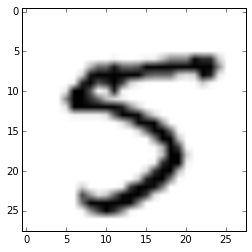

THe label for the figure is [5]


In [224]:

%matplotlib inline
with open('best_model.pkl', 'wb') as f:
                        pickle.dump(classifier, f)
        
number = 103
a = predict(number)
print "THe label for the figure is "+ str(a)

## Let's create a RNN

In [347]:
import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as T
import sys

dtype = theano.config.floatX
learning_rate = 0.05
n_in = 256
n_hid = 1000
n_out = 256
n_epoch = 10


def sample_weights(SizeX, SizeY):
    values = np.ndarray([SizeX, SizeY], dtype = dtype)
    for dx in range(SizeX):
        row_val = np.random.normal(loc = 0.0, scale = 0.1, size=(SizeY,))
        values[dx,:] = row_val
    _,svs,_ = np.linalg.svd(values)
    values = values / svs[0]
    return values


In [348]:

def generate_parameters(n_in, n_hid, n_out):
    b_out = theano.shared(np.zeros(n_out, dtype = dtype))
    b_hid = theano.shared(np.zeros(n_hid, dtype = dtype))
    W_ih = theano.shared(sample_weights(n_in, n_hid))
    W_hh = theano.shared(sample_weights(n_hid, n_hid))
    W_ho = theano.shared(sample_weights(n_hid, n_out))
    h_0 = theano.shared(np.zeros(n_hid, dtype = dtype))
    return h_0, b_out, b_hid, W_ih, W_hh, W_ho

def logistic_function(vec):
    return 1/(1 + T.exp(-vec))
def activ_tan(vec):
    return T.tanh(vec)
def one_step(x_t, hid_s, W_ih, W_hh, W_ho, b_out, b_hid):
    h_t = activ_tan(theano.dot(x_t, W_ih) + theano.dot(hid_s, W_hh) + b_hid)
    return h_t



In [349]:
hid_s, b_out, b_hid, W_ih, W_hh, W_ho = generate_parameters(n_in,n_hid,n_out)

params = [ b_out, b_hid, W_ih, W_hh, W_ho]

x_t = theano.shared(np.random.uniform(size = n_in))

inp = T.matrix(dtype = dtype)

target = T.matrix(dtype = dtype)

hidden_s,_ = theano.scan(fn = one_step, sequences=inp, outputs_info = hid_s, non_sequences = [ W_ih, W_hh, W_ho, b_out, b_hid])

#hid_s = hidden_s[hidden_s.shape[0]-1]

y_t = theano.dot(hidden_s[hidden_s.shape[0]-1], W_ho) + b_out

p_y_given_x = T.nnet.softmax(y_t)

y_t = T.argmax(p_y_given_x, axis = 1)

lr = theano.shared(np.cast[dtype](learning_rate))

cost = -T.sum(target*T.log(p_y_given_x) + (1.- target)*T.log(1. - p_y_given_x))


In [350]:
def get_train_graph(target, inp, cost):
    grads = []
    for param in params:
        grads.append(T.grad(cost, param))
    update = []
    for param,grad in zip(params, grads):
        update.append((param, param - grad*lr))
    train_fn = theano.function(inputs = [inp,target], outputs = cost, updates = update)
    return train_fn


In [351]:

def get_pred_graph(inp):
    predictions = theano.function(inputs = [inp], outputs = y_t, updates = [(hid_s, hidden_s[hidden_s.shape[0]-1])])
    return predictions


In [352]:

def convert_string(file):
    f = open(file,'r')
    text = f.read()
    f.close()
    inp = np.zeros([len(text), 256],dtype=dtype)
    out = np.zeros([len(text), 256],dtype=dtype)
    counter = 0
    for char in text:
        if(counter > 0):
            inp[counter][ord(char)] = 1
            out[counter-1][ord(char)] = 1
        counter = counter + 1
    return [inp, out]


In [353]:

learn_rnn_fn = get_train_graph(target, inp, cost)
pred_rnn_fn = get_pred_graph(inp)

train_data = convert_string("log")


In [357]:
j = 0
def train_rnn(train_data, n_epoch = 100):
    train_err = np.ndarray(n_epoch)
    for i in range(n_epoch):
        for j in range(len(train_data[0])):
            tempInp = np.zeros([1,256],dtype=dtype);
            tempInp[0] = train_data[0][j]
            tempOut = np.zeros([1,256],dtype=dtype);
            tempOut[0] = train_data[1][j]
            train_cost = learn_rnn_fn(tempInp, tempOut)
            sys.stdout.write(chr(pred_rnn_fn(tempInp)))
            train_err[i]=train_err[i]+ train_cost
        train_err[i]= train_err[i]/len(train_data[0])
        print ""
        if train_err[i] > 5*train_err[i-1]:
            break
    return train_err


In [ ]:

train_errors = train_rnn(train_data, n_epoch)
for i in range(0,len(train_data[0])):
    temp = np.zeros([1,256],dtype=dtype);
    temp[0] = train_data[0][i]
    sys.stdout.write(chr(pred_rnn_fn(temp)))



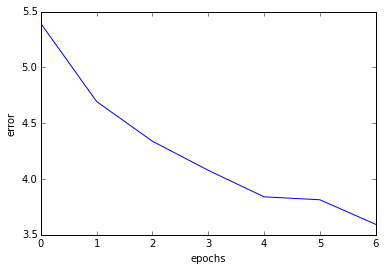

In [359]:
def plot_learning_curve(train_err):
    plt.plot(np.arange(n_epoch), train_errors, 'b-')
    plt.xlabel('epochs')
    plt.ylabel('error')
    plt.show()
plot_learning_curve(train_errors)
